# Etude d'une pièce cubique dans un environnement glacial                         
Réalisée par Hélène ZHANG

## Objectif : Déterminer un modèle viable du cube en limitant les consommations énergétiques

## Sommaire

**I) Présentation générale : Description du bâtiment  
II) Hypothèses  
a) Localisation  
b) Dimension du bâtiment  
c) Définition des matériaux utilisés  
III) Propriétés termo-physique  
IV) Circuit Thermique  
a) Conductances thermiques  
b) Capacités thermiques  
c) Source de flux  
V) Système Equation Différentielle (DAE)  
VI) Modèle en régime stationniaire  
VII) Pour un ordre d'idée de la consommation annuelle du modèle précédent...  
VIII) Pour la suite...  
IX) Modèle dynamique  
X) Optimisation du système : Equipement idéal  
a) Valeurs visées pour chacun des environnements  
b) Paramètre modifiables  
c) Tableau des matériaux  
d) Processus de détermination des équipements idéaux  
e) Conclusion  
XI) Amélioration possible**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem
from dm4bem import read_epw, sol_rad_tilt_surf
# import warnings
# warnings.filterwarnings("ignore", category=RuntimeWarning) 

## Présentation générale : Description du bâtiment


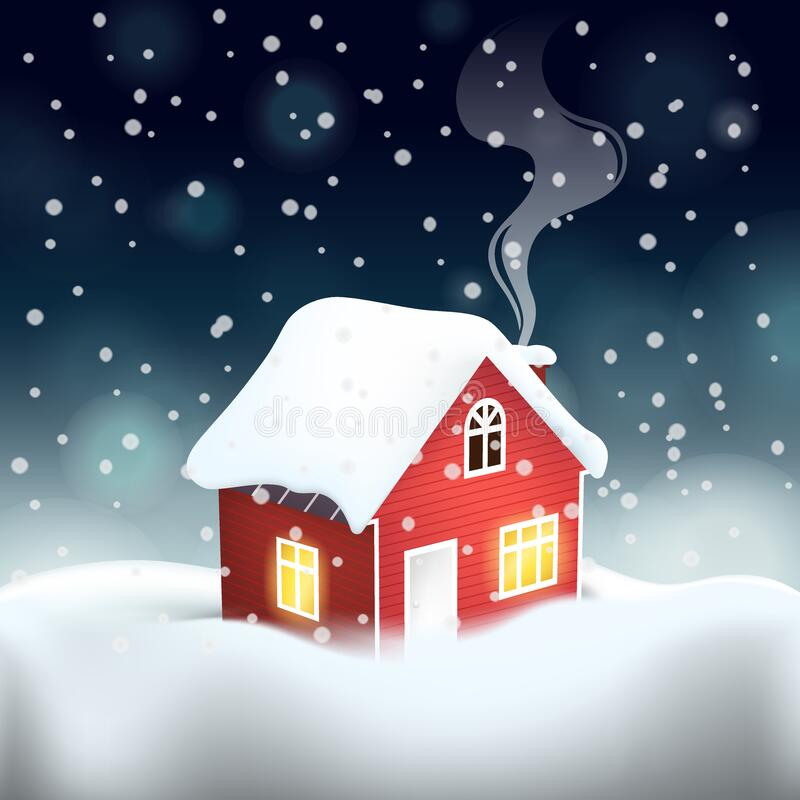
> Figure 1. Image representant la situation générale du projet (de Dreamstime)

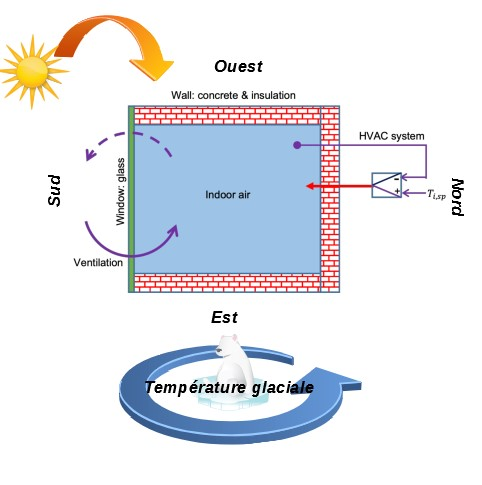
> Figure 2. Schema Représentatif du modèle étudié (ventilation, 5 murs de 2 couches de matériaux, 1 vitre et un correcteur HVAC)


## Hypothèses

Ainsi, les **hypothèses** retenus sur le système sont les suivants :
* Définition de l'orientation du bâtiment : Sud côté vitré
* Localisation : Moscou en Russie
* 5 murs similaires de 2 couches de matériaux (béton et isolation)
* 1 fenêtre vitrée
* 1 mécanisme de ventilation
* Température froide
* Flux solaire sur mur Sud et Est
* Dimension d'un cube (pièce de vie)
* Sol enneigé sauf la surface de contact entre cube et sol
* Correcteur : système de régulateur de température associé au chauffage

### Localisation

L'étude du bâtiment se fait à Moscou, en Russie.  
\
**Remarque :** Moscou est situé dans l'hémisphère nord donc comme la France le soleil se place au sud à midi.

In [2]:
# filename = './Weather_Data/RUS_MOS_Moscow-Vnukovo.AP.275185_TMYx.2007-2021.epw' # Russie-Moscou
# filename = './Weather_Data/ARG_Buenos.Aires.875760_IWEC.epw' # Argentine-Buenos_Aires
filename = './Weather_Data/ZAF_GT_Johannesburg-Tambo.Intl.AP.683680_TMYx.2007-2021.epw' # Afrique du Sud-Johannesburg

# Lecture du weatherdata
[data, meta] = read_epw(filename, coerce_year=None)

# Selection des paramètres
weather_data = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
weather_data.index = weather_data.index.map(lambda t: t.replace(year=2008))

# Selectionner date
start_date = '2008-11-30'
end_date = '2008-12-01'

# Ordonner les dates
weather_data = weather_data[(
    weather_data.index >= start_date) & (
    weather_data.index < end_date)]
del data
weather_data

,temp_air,dir_n_rad,dif_h_rad
2008-11-30 00:00:00+02:00,19.0,0,0
2008-11-30 01:00:00+02:00,18.0,0,0
2008-11-30 02:00:00+02:00,17.7,0,0
2008-11-30 03:00:00+02:00,17.0,0,0
2008-11-30 04:00:00+02:00,17.0,0,0
2008-11-30 05:00:00+02:00,15.9,422,48
2008-11-30 06:00:00+02:00,16.0,683,82
2008-11-30 07:00:00+02:00,18.0,835,99
2008-11-30 08:00:00+02:00,18.8,908,112
2008-11-30 09:00:00+02:00,21.0,950,120


### Dimension du bâtiment
- $l=3 \: \mathrm{m}$ - Longueur d'un côté du cube (On rappelle qu'une chambre a pour dimension minimale 9 m²
- $S_v=l^2$   - Surface de la vitre
- $S_m = S_i = 5 \times S_g$   - Surface des murs identiques

In [3]:
l = 3               # m longueur d
Sv = l**2           # m² surface of the glass wall
Sm = Si = 5 * Sv    # m² surface of concrete & insulation of the 5 walls

### Définition des matériaux utilisés

In [4]:
# Pour la dernière partie du projet, le béton est l'élément à changer pour une construction idéale (voir partie optimisation). Les valeurs de la colonne sont donc adaptés selon le matériau étudié mais le nom commun reste le béton. Pareillement pour le verre dans le cas d'une vitres sur les 4 faces.



# Béton + isolant
wall = {'Conductivite': [1.4, 0.027, 1.4],  # W/(m·K)
        'Densite': [2300, 55, 2500],        # kg/m³
        'Capacite thermique massique': [880, 1210, 750],  # J/(kg·K)
        'Epaisseur': [0.2, 0.08, 0.004],
        'Surface': [5 * l**2, 5 * l**2, l**2],  # m²
        'Nb de couches par mur': [1, 1, 1]} 

"""
# Bois + isolant
wall = {'Conductivite': [0.1825, 0.027, 1.4],  # W/(m·K)
        'Densite': [735, 55, 2500],        # kg/m³
        'Capacite thermique massique': [2300, 1210, 750],  # J/(kg·K)
        'Epaisseur': [0.2, 0.08, 0.004],
        'Surface': [5 * l**2, 5 * l**2, l**2],  # m²
        'Nb de couches par mur': [1, 1, 1]}
"""
"""
# Terre cuite + isolant
wall = {'Conductivite': [0.825, 0.027, 1.4],  # W/(m·K)
        'Densite': [1700, 55, 2500],        # kg/m³
        'Capacite thermique massique': [1000, 1210, 750],  # J/(kg·K)
        'Epaisseur': [0.2, 0.08, 0.004],
        'Surface': [5 * l**2, 5 * l**2, l**2],  # m²
        'Nb de couches par mur': [1, 1, 1]}
"""
"""
# Vitre sur 4 murs
wall = {'Conductivite': [1.4, 1.4, 1.4],  # W/(m·K)
        'Densite': [2300, 2300, 2500],        # kg/m³
        'Capacite thermique massique': [880, 880, 750],  # J/(kg·K)
        'Epaisseur': [0.004, 0.004, 0.004],
        'Surface': [5 * l**2, 5 * l**2, l**2],  # m²
        'Nb de couches par mur': [1, 1, 1]} 
"""

wall = pd.DataFrame(wall, index=['Beton', 'Isolant', 'Verre'])
wall

,Conductivite,Densite,Capacite thermique massique,Epaisseur,Surface,Nb de couches par mur
Beton,1.400,2300,880,0.200,45,1
Isolant,0.027,55,1210,0.080,45,1
Verre,1.400,2500,750,0.004,9,1


Chaque surface a une certaine émissivité, elles sont définies de la manière suivante :  
  
**En grande longueur d'onde**
- Emissivité de la surface extérieur du mur (béton)
- Emissivité du verre  

**En courte longueur d'onde**
- Absorptivité de la surface blanche du mur (épaisseur nulle)
- Absorptivité du verre
- Transmittance du verre

In [5]:
# à faire un tableau si temps

# Surface du mur (béton)

# ε_bg = 0.85       # Emissivité : Grande longueur d'onde ---> béton
# ε_bg = 0.84       # ---> bois
# ε_bg = 0.81       # ---> terre cuite
ε_bg = 0.90       # ---> vitre

# Couleur des surfaces
α_coulc = 0.25    # Absorptivité : Courte longueur d'onde : mur de couleur blanche

# Verre
ε_vg = 0.90       # Emissivité : Grande longueur d'onde
α_vc = 0.38       # Absorptivité : Courte longueur d'onde
τ_vc = 0.30       # Transmittance : Courte longueur d'onde

Le coefficient de Stefan-Boltzmann est :

In [6]:
σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant
print(f'σ = {σ} W/(m²⋅K⁴)')

σ = 5.67e-08 W/(m²⋅K⁴)


**Facteur de forme entre les surfaces murales et la surface de la vitre**

In [7]:
Fmv = 1 / 5     # view factor wall - glass
print(f'Fmv = {Fmv}')

Fmv = 0.2


**Coefficient d'échange convectif, h**

In [8]:
h = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/(m²⋅K)
h

,in,out
h,8.0,25


## Propriétés thermo-physique

In [9]:
air = {'Densite': 1.2,                      # kg/m³
       'Capacite thermique massique': 1000}               # J/(kg·K)
# pd.DataFrame.from_dict(air, orient='index', columns=['air'])
pd.DataFrame(air, index=['Air'])

,Densite,Capacite thermique massique
Air,1.2,1000


## Circuit Thermique

**Transferts de chaleur :**
- à travers le mur (béton et isolation), 
- à travers l'épaisseur de la vitre,
- par ventilation (VMC),
- à partir d'une source interne,
- du système HVAC.

HVAC (chauffage)

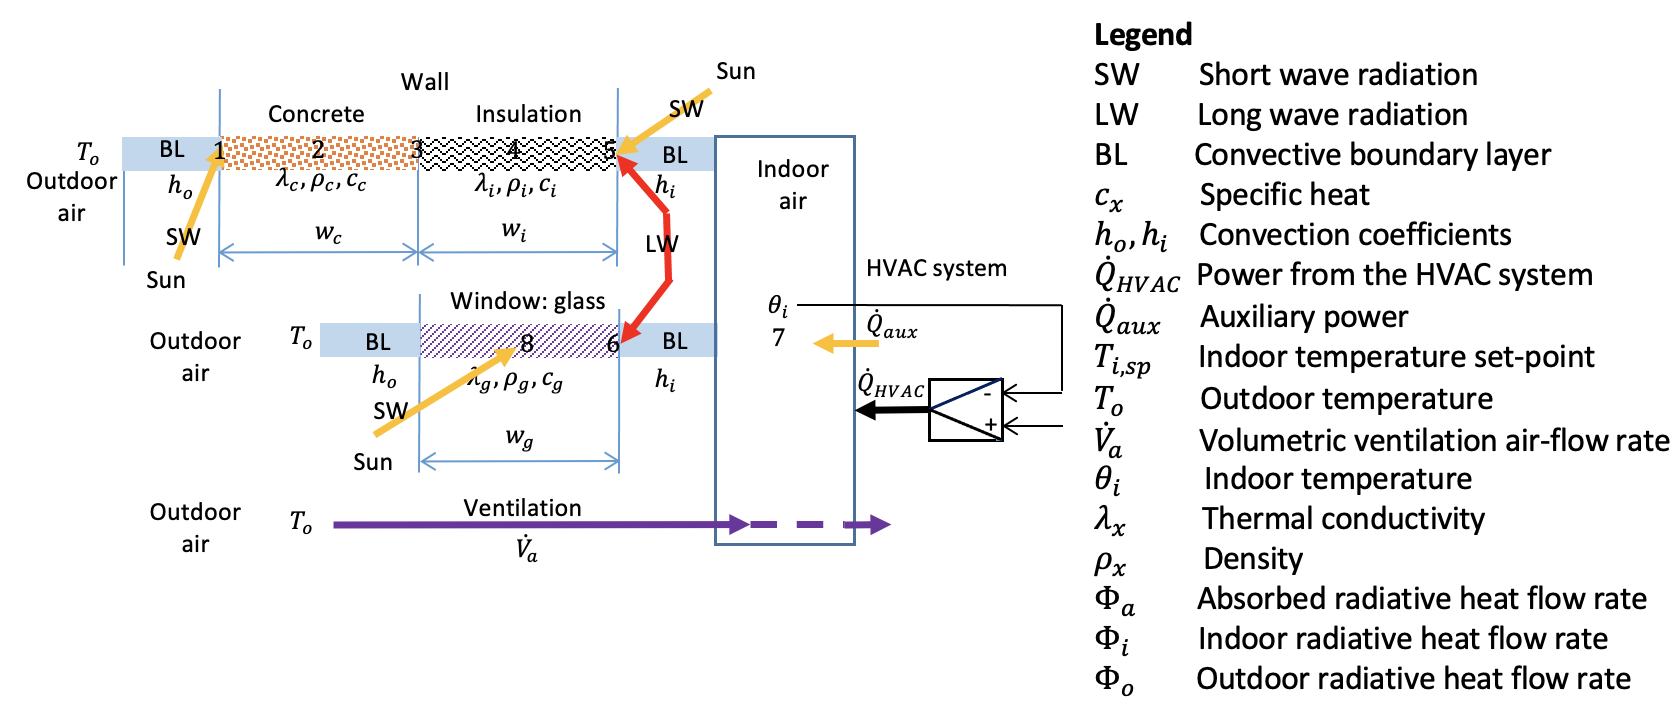
> Figure 3. Les différents transferts de chaleur appliqués sur le cube

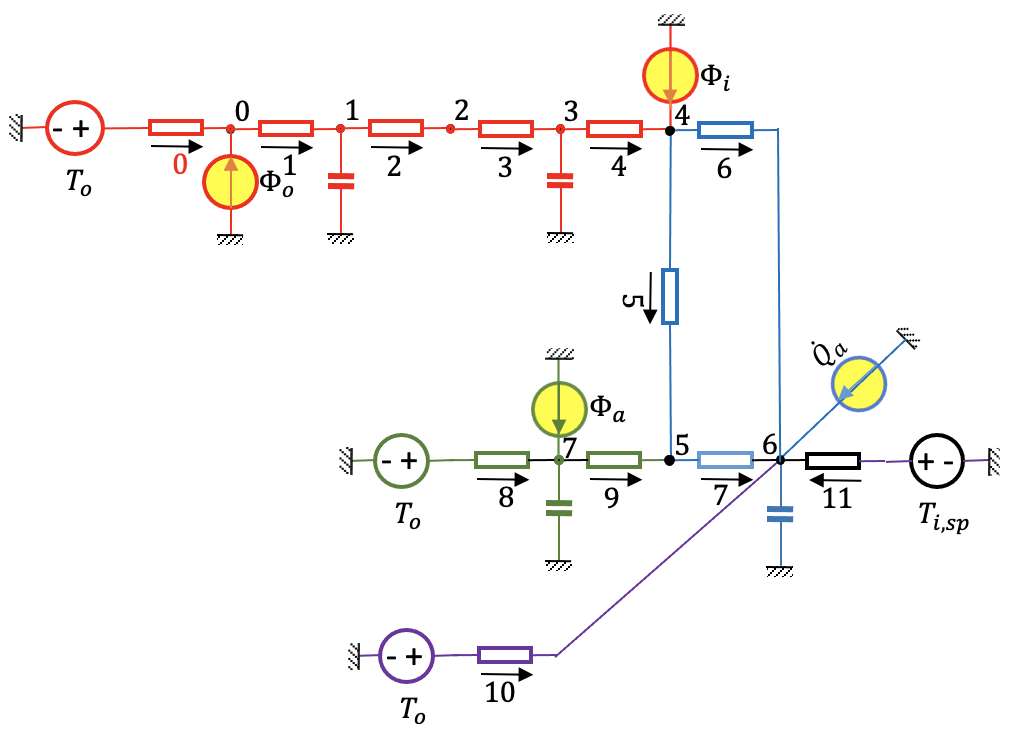
> Figure 4. Schéma du circuit thermique du système étudié

La figure 4 montre le modèle suivant :
- Mur en béton et isolant : en rouge;
- Fenêtre en verre : en vert;
- Ventilation : en violet;
- Volume intérieur : en bleu (conductances 6 & 7 pour la convection; conductance 5 pour les échanges radiatifs entre les murs et la fenêtre);
- Système HVAC : en noir.
    
    
Les sources sont :
- $T_ext$ - Température extérieur, °C;
- $T_{i,sp}$ - Température visée par le correcteur, °C;
- $\Phi_{s,n,ext}$ - Flux solaire **et Flux solaire dévié par la neige** reçus à la surface des murs extérieurs, W;
- $\Phi_{s,n,int}$ - Flux solaire **et Flux solaire dévié par la neige** reçus à la surface des murs intérieurs, W;
- $\dot{Q}_{int}$ - Flux interne du bâtiment (ex : générés par les occupants, les fils électriques, etc.), W;
- $\Phi_a$ - Flux solaire reçu sur la vitre, W.

### Conductances Thermiques

**Conduction**

Les conductances conductives (W/K) 1, 2, 3, et 4 du circuit thermique de la figure 4 sont traversées par des flux générés par conduction. Elles sont de la forme :
$$G_{cd} = \frac{\lambda}{w}S$$

Avec :

- $\lambda$ - Conductivité Thermique, W/(m⋅K);
- $w$ - Epaisseur du matériau, m;
- $S$ - Surface du mur, m².

In [10]:
# Conduction
G_cd = wall['Conductivite'] / wall['Epaisseur'] * wall['Surface']
pd.DataFrame(G_cd, columns={'Conductance'})

,Conductance
Beton,315.0000
Isolant,15.1875
Verre,3150.0000


**Convection**

Les conductances convectives (W/K) 0, 6 and 7 sont traversées par des flux générés par convection. Elles sont de la forme :
$$G_{cv} = {h S}$$

Avec :
- $h$ - Coefficient Convectif, W/(m²⋅K);
- $S$ - Surface du mur, m². 

In [11]:
# Convection
G_cvm = h * wall['Surface'][0]     # Mur en béton
G_cvv = h * wall['Surface'][2]     # Verre

**Echanges radiatifs**

Il y en a plusieurs dans le système :

* Entre noeuds 4 et 5, échange entre mur et vitre
* Echange entre sol enneigé et mur extérieur ---> Sauf qu'on le néglige car $S_{ext}$ << $S_{solneige}$, le facteur de forme devient nul du sol au mur, ce qui supprime la liaison entre les 2 surfaces (conductance radiative nulle).

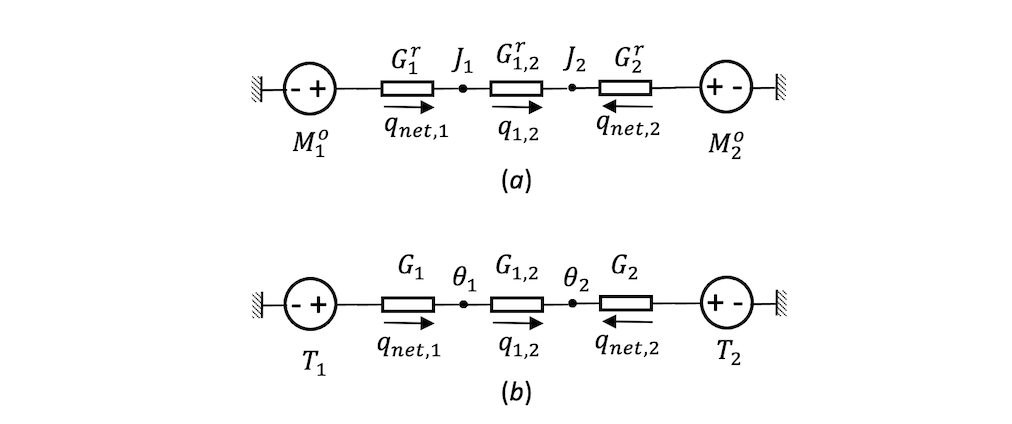
> Figure 5. Echange radiatif entre 2 surfaces : a) modèle emmittance (source) et radiosité (noeuds), b) modèle linéaire de l'émittance (source de température) et de radiosité (noeuds de température)


Les différentes conductances radiatives sont calculées avec les expressions suivantes :
$$G_{1}^{r} = \frac{\varepsilon_1}{1 - \varepsilon_1} S_1$$

$$G_{1,2}^{r} = F_{1,2} S_1 = F_{2,1} S_2$$

$$G_{2}^{r} = \frac{\varepsilon_2}{1 - \varepsilon_2} S_2$$

In [12]:
Tm = 15 + 273   # K, mean temp for radiative exchange

# Echange radiatif entre verre et isolant
GR1 = 4 * σ * Tm**3 * ε_bg / (1 - ε_bg) * wall['Surface']['Isolant'] # 1 : Isolant
GR12 = 4 * σ * Tm**3 * Fmv * wall['Surface']['Isolant']
GR2 = 4 * σ * Tm**3 * ε_vg / (1 - ε_vg) * wall['Surface']['Verre'] # 2 : Verre

La conductance équivalente de l'échange entre isolant et verre est : 
$$GR = \frac{1}{1/G_1 + 1/G_{1,2} + 1/G_2}$$

In [13]:
GR = 1 / (1 / GR1 + 1 / GR12 + 1 / GR2)

**Advection**

Le débit volumique de l'air, en m³/s, est :
$$\dot{V}_a = \frac{\mathrm{ACH}}{3600} V_a$$

In [14]:
Va = l**3                   # m³ volume de l'air
ACH = 1000                    # 1/h quantité d'air entrant par heure
Va_dot = ACH / 3600 * Va    # m³/s Débit volumique d'air

Ainsi on peut calculer la conductance advectif, c'est-à-dire celle qui est traversée par un flux généré par advection :
$$G_v = \rho_a c_a \dot{V}_a$$

In [15]:
# ventilation & advection
Gv = air['Densite'] * air['Capacite thermique massique'] * Va_dot

**Correcteur**

In [16]:
# P-controler gain
# Kp = 1e4            # correction presque maximale Kp -> ∞
Kp = 1e-3           # pas de correction Kp -> 0
# Kp = 0
# Kp = 1              # Correction minime

**Equivalence des conductances**

Les conductances conductifs et convectifs entre vitre-air sont parallèles, leur résistance équivalente vaut alors :
$$ G_{equivv} = \frac{1}{1/G_{cvv } + 1/(2 G_{cd})} =  
\frac{1}{\frac{1}{h_{out} S_v} + \frac{w / 2}{\lambda S_v}}
$$

In [17]:
# verre : convection et conduction
G_equivv = float(1 / (1 / G_cvv['out'] + 1 / (2 * G_cd['Verre'])))

### Capacités thermiques

**Mur**  
\
Les capacités thermiques du mur, en J/kg, sont de la forme :

$$C_w= m_w c_w= \rho_w c_w w_w S_w$$

Avec :

- $m_w = \rho_w w_w S_w$ - Masse du mur, kg;
- $c_w$ - Capacité thermique massique du matériau, J/(kg⋅K);
- $\rho_w$ - Densité, kg/m³;
- $w_w$ - Epaisseur du mur, m;
- $S_w$ - Surface du mur, m².

In [18]:
Cw = wall['Densite'] * wall['Capacite thermique massique'] * wall['Surface'] * wall['Epaisseur']

**Air**  
\
De façon analogique, on en déduit que :
$$C_a = m_a c_a = \rho_a c_a V_a$$

Avec :

- $m_a = \rho_a V_a$ - Masse du, kg;
- $\rho_w$ - Densité de l'air, kg/m³;
- $c_a$ - Capacité thermique massique du matériau, J/(kg⋅K);
- $V_a$ - Volume d'air, m³.

In [19]:
Cw['Air'] = air['Densite'] * air['Capacite thermique massique'] * Va
pd.DataFrame(Cw, columns={'Capacite'})

,Capacite
Beton,18216000.0
Isolant,239580.0
Verre,67500.0
Air,32400.0


### Source de flux

**Correction Temperature par HVAC**  
Le flux délivré par le HVAC dépend uniquement de la température extérieure($\theta_i$) et de la valeur visée($T_{i, sp}$) avec bien sûr son coefficient correctif($K_p$) :
$$ q_{HVAC} = K_p (T_{i, sp} - \theta_i)$$

**Flux solaire**   
de l'algorithme : sol_rad_tilt_surf

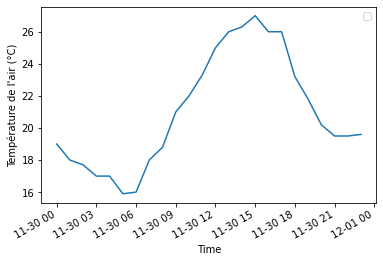

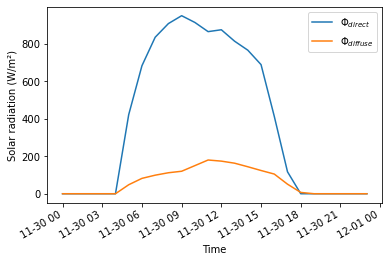

In [20]:
# Evolution temporelle de la température 
weather_data[['temp_air']].plot()
plt.xlabel("Time")
plt.ylabel("Température de l'air (°C)")
plt.legend([])
plt.show()

# Evolution du flux solaire par rapport à l'intervalle de temps étudié
weather_data[['dir_n_rad', 'dif_h_rad']].plot()
plt.xlabel("Time")
plt.ylabel("Solar radiation (W/m²)")
plt.legend(['$Φ_{direct}$', '$Φ_{diffuse}$'])
plt.show()

Sur cet intervalle de temps, il y a peu de jours où le soleil est présent.

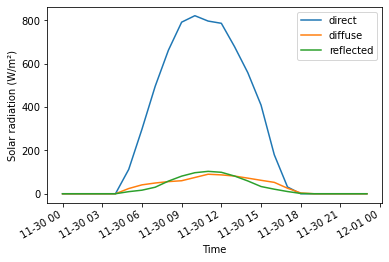

In [21]:
# Definition orientation
surface_orientation_S = {'slope': 90, 
                       'azimuth': 0, 
                       'latitude': 45} # A redéfinir--> recherche google
pd.Series(surface_orientation_S)

albedo = 0.2    # Consière qu'il neige souvent donc neige fraîche, 0.2 pour les autres localisations

rad_surf = sol_rad_tilt_surf(
    weather_data, surface_orientation_S, albedo)

rad_surf.plot()
plt.xlabel("Time")
plt.ylabel("Solar radiation (W/m²)")
plt.show()

> Figure 6. Evolution du flux solaire direct, diffusé et réfléchi par rapport au temps

On constate qu'une grande partie du flux solaire que reçoit un des murs vient de sa réflection avec l'environnement soit la neige. Les rayons provenant de la réflection sur le sol ne sont pas négligeables. Il faut donc puiser le plus possible de cette source par la suite.

La somme de ces 3 flux : direct, diffuse et reflection donne le flux total reçu par la surface murale :
$$ G_{sr} = G_{dir} + G_{dif} + G_r$$

**Mur Sud**

In [22]:
β = surface_orientation_S['slope']
γ = surface_orientation_S['azimuth']
ϕ = surface_orientation_S['latitude']

# Conversion en rad
β = β * np.pi / 180
γ = γ * np.pi / 180
ϕ = ϕ * np.pi / 180

n = weather_data.index.dayofyear

* Direct Radiation

In [23]:
# Angle entre le soleil à 9h et l'équateur
declination_angle = 23.45 * np.sin(360 * (284 + n) / 365 * np.pi / 180)
δ = declination_angle * np.pi / 180

# Recherche de ω 
hour = weather_data.index.hour
minute = weather_data.index.minute + 60
hour_angle = 15 * ((hour + minute / 60) - 12)   # deg
ω = hour_angle * np.pi / 180                    # rad

# Détermination de l'angle entre la normale à la surface (mur) et du soleil
theta = np.sin(δ) * np.sin(ϕ) * np.cos(β)
theta -= np.sin(δ) * np.cos(ϕ) * np.sin(β) * np.cos(γ)
theta += np.cos(δ) * np.cos(ϕ) * np.cos(β) * np.cos(ω)
theta += np.cos(δ) * np.sin(ϕ) * np.sin(β) * np.cos(γ) * np.cos(ω)
theta += np.cos(δ) * np.sin(β) * np.sin(γ) * np.sin(ω)
theta = np.array(np.arccos(theta))
theta[theta > (np.pi / 2)] = np.pi / 2

# Flux solaire Direct
dir_rad_S = weather_data["dir_n_rad"] * np.cos(theta)
dir_rad_S[dir_rad_S < 0] = 0

- Radiation Diffusée

In [24]:
dif_rad_S = weather_data["dif_h_rad"] * (1 + np.cos(β)) / 2

- Radiation après réflection au sol

In [25]:
# Calcul de la radiation horizontale diffusée
gamma = np.cos(δ) * np.cos(ϕ) * np.cos(ω)
gamma += np.sin(δ) * np.sin(ϕ)
gamma = np.array(np.arcsin(gamma))
gamma[gamma < 1e-5] = 1e-5

dir_h_rad = weather_data["dir_n_rad"] * np.sin(gamma)

# Flux solaire après réflection sur le sol
ref_rad_S = (dir_h_rad + weather_data["dif_h_rad"]) * albedo * (1 + np.cos(β) / 2)

- Radiation Totale

In [26]:
Gtot_S = dir_rad_S + dif_rad_S + ref_rad_S
Gtot_S

2008-11-30 00:00:00+02:00      0.000000
2008-11-30 01:00:00+02:00      0.000000
2008-11-30 02:00:00+02:00      0.000000
2008-11-30 03:00:00+02:00      0.000000
2008-11-30 04:00:00+02:00      0.000000
2008-11-30 05:00:00+02:00    145.903201
2008-11-30 06:00:00+02:00    354.968432
2008-11-30 07:00:00+02:00    575.282178
2008-11-30 08:00:00+02:00    776.454155
2008-11-30 09:00:00+02:00    933.029042
2008-11-30 10:00:00+02:00    993.637178
2008-11-30 11:00:00+02:00    990.167780
2008-11-30 12:00:00+02:00    972.519399
2008-11-30 13:00:00+02:00    841.583832
2008-11-30 14:00:00+02:00    689.687095
2008-11-30 15:00:00+02:00    504.311042
2008-11-30 16:00:00+02:00    253.435231
2008-11-30 17:00:00+02:00     66.836196
2008-11-30 18:00:00+02:00      4.900000
2008-11-30 19:00:00+02:00      0.000000
2008-11-30 20:00:00+02:00      0.000000
2008-11-30 21:00:00+02:00      0.000000
2008-11-30 22:00:00+02:00      0.000000
2008-11-30 23:00:00+02:00      0.000000
dtype: float64

**Ensemble Mur Nord, Est et Ouest**

On procède de la même façon pour déterminer le flux total solaire que reçoit les murs Nord, Est et Ouest.

- Nord

In [27]:
surface_orientation_N = {'slope': 90, 
                       'azimuth': 180, 
                       'latitude': 45} # A redéfinir--> recherche google
pd.Series(surface_orientation_N)

albedo = 0.70 # Consière qu'il neige souvent

rad_surf = sol_rad_tilt_surf(
    weather_data, surface_orientation_N, albedo)

β = surface_orientation_N['slope']
γ = surface_orientation_N['azimuth']
ϕ = surface_orientation_N['latitude']

# Conversion en rad
β = β * np.pi / 180
γ = γ * np.pi / 180
ϕ = ϕ * np.pi / 180

n = weather_data.index.dayofyear

# Angle entre le soleil à 9h et l'équateur
declination_angle = 23.45 * np.sin(360 * (284 + n) / 365 * np.pi / 180)
δ = declination_angle * np.pi / 180

# Recherche de ω 
hour = weather_data.index.hour
minute = weather_data.index.minute + 60
hour_angle = 15 * ((hour + minute / 60) - 12)   # deg
ω = hour_angle * np.pi / 180                    # rad

# Détermination de l'angle entre la normale à la surface (mur) et du soleil
theta = np.sin(δ) * np.sin(ϕ) * np.cos(β)
theta -= np.sin(δ) * np.cos(ϕ) * np.sin(β) * np.cos(γ)
theta += np.cos(δ) * np.cos(ϕ) * np.cos(β) * np.cos(ω)
theta += np.cos(δ) * np.sin(ϕ) * np.sin(β) * np.cos(γ) * np.cos(ω)
theta += np.cos(δ) * np.sin(β) * np.sin(γ) * np.sin(ω)
theta = np.array(np.arccos(theta))
theta[theta > (np.pi / 2)] = np.pi / 2

# Flux solaire Direct
dir_rad_N = weather_data["dir_n_rad"] * np.cos(theta)
dir_rad_N[dir_rad_N < 0] = 0
dir_rad_N 

# Flux solaire diffusé
dif_rad_N = weather_data["dif_h_rad"] * (1 + np.cos(β)) / 2

# Calcul de la radiation horizontale diffusée
gamma = np.cos(δ) * np.cos(ϕ) * np.cos(ω)
gamma += np.sin(δ) * np.sin(ϕ)
gamma = np.array(np.arcsin(gamma))
gamma[gamma < 1e-5] = 1e-5

dir_h_rad = weather_data["dir_n_rad"] * np.sin(gamma)

# Flux solaire après réflection sur le sol
ref_rad_N = (dir_h_rad + weather_data["dif_h_rad"]) * albedo * (1 + np.cos(β) / 2)

# Flux total
Gtot_N = dir_rad_N + dif_rad_N + ref_rad_N
Gtot_N

2008-11-30 00:00:00+02:00      0.000000
2008-11-30 01:00:00+02:00      0.000000
2008-11-30 02:00:00+02:00      0.000000
2008-11-30 03:00:00+02:00      0.000000
2008-11-30 04:00:00+02:00      0.000000
2008-11-30 05:00:00+02:00     57.602954
2008-11-30 06:00:00+02:00     98.404781
2008-11-30 07:00:00+02:00    154.711690
2008-11-30 08:00:00+02:00    259.689180
2008-11-30 09:00:00+02:00    344.318017
2008-11-30 10:00:00+02:00    414.599775
2008-11-30 11:00:00+02:00    451.539115
2008-11-30 12:00:00+02:00    433.389500
2008-11-30 13:00:00+02:00    367.240912
2008-11-30 14:00:00+02:00    278.495498
2008-11-30 15:00:00+02:00    178.432520
2008-11-30 16:00:00+02:00    126.002891
2008-11-30 17:00:00+02:00     61.200819
2008-11-30 18:00:00+02:00      8.400000
2008-11-30 19:00:00+02:00      0.000000
2008-11-30 20:00:00+02:00      0.000000
2008-11-30 21:00:00+02:00      0.000000
2008-11-30 22:00:00+02:00      0.000000
2008-11-30 23:00:00+02:00      0.000000
dtype: float64

- Ouest

In [28]:
surface_orientation_O = {'slope': 90, 
                       'azimuth': 90, 
                       'latitude': 45} # A redéfinir--> recherche google
pd.Series(surface_orientation_O)

albedo = 0.70 # Consière qu'il neige souvent

rad_surf = sol_rad_tilt_surf(
    weather_data, surface_orientation_O, albedo)

β = surface_orientation_O['slope']
γ = surface_orientation_O['azimuth']
ϕ = surface_orientation_O['latitude']

# Conversion en rad
β = β * np.pi / 180
γ = γ * np.pi / 180
ϕ = ϕ * np.pi / 180

n = weather_data.index.dayofyear

# Angle entre le soleil à 9h et l'équateur
declination_angle = 23.45 * np.sin(360 * (284 + n) / 365 * np.pi / 180)
δ = declination_angle * np.pi / 180

# Recherche de ω 
hour = weather_data.index.hour
minute = weather_data.index.minute + 60
hour_angle = 15 * ((hour + minute / 60) - 12)   # deg
ω = hour_angle * np.pi / 180                    # rad

# Détermination de l'angle entre la normale à la surface (mur) et du soleil
theta = np.sin(δ) * np.sin(ϕ) * np.cos(β)
theta -= np.sin(δ) * np.cos(ϕ) * np.sin(β) * np.cos(γ)
theta += np.cos(δ) * np.cos(ϕ) * np.cos(β) * np.cos(ω)
theta += np.cos(δ) * np.sin(ϕ) * np.sin(β) * np.cos(γ) * np.cos(ω)
theta += np.cos(δ) * np.sin(β) * np.sin(γ) * np.sin(ω)
theta = np.array(np.arccos(theta))
theta[theta > (np.pi / 2)] = np.pi / 2

# Flux solaire Direct
dir_rad_O = weather_data["dir_n_rad"] * np.cos(theta)
dir_rad_O[dir_rad_O < 0] = 0
dir_rad_O 

# Flux solaire diffusé
dif_rad_O = weather_data["dif_h_rad"] * (1 + np.cos(β)) / 2

# Calcul de la radiation horizontale diffusée
gamma = np.cos(δ) * np.cos(ϕ) * np.cos(ω)
gamma += np.sin(δ) * np.sin(ϕ)
gamma = np.array(np.arcsin(gamma))
gamma[gamma < 1e-5] = 1e-5

dir_h_rad = weather_data["dir_n_rad"] * np.sin(gamma)

# Flux solaire après réflection sur le sol
ref_rad_O = (dir_h_rad + weather_data["dif_h_rad"]) * albedo * (1 + np.cos(β) / 2)

# Flux total
Gtot_O = dir_rad_O + dif_rad_O + ref_rad_O
Gtot_O

2008-11-30 00:00:00+02:00      0.000000
2008-11-30 01:00:00+02:00      0.000000
2008-11-30 02:00:00+02:00      0.000000
2008-11-30 03:00:00+02:00      0.000000
2008-11-30 04:00:00+02:00      0.000000
2008-11-30 05:00:00+02:00     57.602954
2008-11-30 06:00:00+02:00     98.404781
2008-11-30 07:00:00+02:00    154.711690
2008-11-30 08:00:00+02:00    259.689180
2008-11-30 09:00:00+02:00    344.318017
2008-11-30 10:00:00+02:00    414.599775
2008-11-30 11:00:00+02:00    451.539115
2008-11-30 12:00:00+02:00    643.205824
2008-11-30 13:00:00+02:00    744.317352
2008-11-30 14:00:00+02:00    780.316417
2008-11-30 15:00:00+02:00    731.253916
2008-11-30 16:00:00+02:00    495.600216
2008-11-30 17:00:00+02:00    169.598715
2008-11-30 18:00:00+02:00      8.400000
2008-11-30 19:00:00+02:00      0.000000
2008-11-30 20:00:00+02:00      0.000000
2008-11-30 21:00:00+02:00      0.000000
2008-11-30 22:00:00+02:00      0.000000
2008-11-30 23:00:00+02:00      0.000000
dtype: float64

- Est

In [29]:
surface_orientation_E = {'slope': 90, 
                       'azimuth': 270, 
                       'latitude': 45} # A redéfinir--> recherche google
pd.Series(surface_orientation_E)

albedo = 0.70 # Consière qu'il neige souvent

rad_surf = sol_rad_tilt_surf(
    weather_data, surface_orientation_E, albedo)

β = surface_orientation_E['slope']
γ = surface_orientation_E['azimuth']
ϕ = surface_orientation_E['latitude']

# Conversion en rad
β = β * np.pi / 180
γ = γ * np.pi / 180
ϕ = ϕ * np.pi / 180

n = weather_data.index.dayofyear

# Angle entre le soleil à 9h et l'équateur
declination_angle = 23.45 * np.sin(360 * (284 + n) / 365 * np.pi / 180)
δ = declination_angle * np.pi / 180

# Recherche de ω 
hour = weather_data.index.hour
minute = weather_data.index.minute + 60
hour_angle = 15 * ((hour + minute / 60) - 12)   # deg
ω = hour_angle * np.pi / 180                    # rad

# Détermination de l'angle entre la normale à la surface (mur) et du soleil
theta = np.sin(δ) * np.sin(ϕ) * np.cos(β)
theta -= np.sin(δ) * np.cos(ϕ) * np.sin(β) * np.cos(γ)
theta += np.cos(δ) * np.cos(ϕ) * np.cos(β) * np.cos(ω)
theta += np.cos(δ) * np.sin(ϕ) * np.sin(β) * np.cos(γ) * np.cos(ω)
theta += np.cos(δ) * np.sin(β) * np.sin(γ) * np.sin(ω)
theta = np.array(np.arccos(theta))
theta[theta > (np.pi / 2)] = np.pi / 2

# Flux solaire Direct
dir_rad_E = weather_data["dir_n_rad"] * np.cos(theta)
dir_rad_E[dir_rad_E < 0] = 0
dir_rad_E 

# Flux solaire diffusé
dif_rad_E = weather_data["dif_h_rad"] * (1 + np.cos(β)) / 2

# Calcul de la radiation horizontale diffusée
gamma = np.cos(δ) * np.cos(ϕ) * np.cos(ω)
gamma += np.sin(δ) * np.sin(ϕ)
gamma = np.array(np.arcsin(gamma))
gamma[gamma < 1e-5] = 1e-5

dir_h_rad = weather_data["dir_n_rad"] * np.sin(gamma)

# Flux solaire après réflection sur le sol
ref_rad_E = (dir_h_rad + weather_data["dif_h_rad"]) * albedo * (1 + np.cos(β) / 2)

# Flux total
Gtot_E = dir_rad_E + dif_rad_E + ref_rad_E
Gtot_E

2008-11-30 00:00:00+02:00      0.000000
2008-11-30 01:00:00+02:00      0.000000
2008-11-30 02:00:00+02:00      0.000000
2008-11-30 03:00:00+02:00      0.000000
2008-11-30 04:00:00+02:00      0.000000
2008-11-30 05:00:00+02:00    448.576561
2008-11-30 06:00:00+02:00    709.627476
2008-11-30 07:00:00+02:00    824.676662
2008-11-30 08:00:00+02:00    854.536953
2008-11-30 09:00:00+02:00    784.394944
2008-11-30 10:00:00+02:00    633.767912
2008-11-30 11:00:00+02:00    451.539115
2008-11-30 12:00:00+02:00    433.389500
2008-11-30 13:00:00+02:00    367.240912
2008-11-30 14:00:00+02:00    278.495498
2008-11-30 15:00:00+02:00    178.432520
2008-11-30 16:00:00+02:00    126.002891
2008-11-30 17:00:00+02:00     61.200819
2008-11-30 18:00:00+02:00      8.400000
2008-11-30 19:00:00+02:00      0.000000
2008-11-30 20:00:00+02:00      0.000000
2008-11-30 21:00:00+02:00      0.000000
2008-11-30 22:00:00+02:00      0.000000
2008-11-30 23:00:00+02:00      0.000000
dtype: float64

In [30]:
# FLux total direct
Gtot_dir = dir_rad_N + dir_rad_E + dir_rad_O

# Flux total
Gtot_NEO = Gtot_N + Gtot_E + Gtot_O

**Flux radiatif mur interne**

Le flux radiatif des murs internes est calculé à partir des opérations matricielles, il en résulte :
$$ \Phi = S E $$

In [31]:
I = np.identity(2)
  
ρ = np.zeros([2, 2])
ρ[0, 0], ρ[1, 1] = 1-ε_bg, 1-α_vc-τ_vc

F = np.zeros([2, 2])
F[0, 0], F[1, 1] = 1-Fmv, 0
F[0, 1], F[1, 0] = Fmv, 1

sum_dir = 0
sum_S = 0
for i in range (len(Gtot_dir)) : 
    sum_dir += Gtot_dir[i]
    sum_S += dir_rad_S[i]

moy_dir = sum_dir/len(Gtot_dir)
moy_S = sum_S/len(dir_rad_S)

E0 = [[moy_dir], [moy_S]]

E = ((I-ρ.dot(F))**(-1)).dot(E0)

# Calcul du flux radiatif interne
S = np.zeros([2, 2])
S[0, 0], S[1, 1] = Sm, Sv

ΦRint = S.dot(E)
ΦRint

array([[-610521.57940806],
       [  -3429.80817701]])

**Flux interne**

In [32]:
Φint = 100*1 # 1 personne dans le bâti

## Système Equation Différentielle (DAE) 

**Matrice de Connexion**

In [33]:
A = np.zeros([12, 8])       # n° of branches X n° of nodes
A[0, 0] = 1                 # branche 0: -> node 0
A[1, 0], A[1, 1] = -1, 1    # branche 1: node 0 -> node 1
A[2, 1], A[2, 2] = -1, 1    # branche 2: node 1 -> node 2
A[3, 2], A[3, 3] = -1, 1    # branche 3: node 2 -> node 3
A[4, 3], A[4, 4] = -1, 1    # branche 4: node 3 -> node 4
A[5, 4], A[5, 5] = -1, 1    # branche 5: node 4 -> node 5
A[6, 4], A[6, 6] = -1, 1    # branche 6: node 4 -> node 6
A[7, 5], A[7, 6] = -1, 1    # branche 7: node 5 -> node 6
A[8, 7] = 1                 # branche 8: -> node 7
A[9, 5], A[9, 7] = 1, -1    # branche 9: node 5 -> node 7
A[10, 6] = 1                # branche 10: -> node 6
A[11, 6] = 1                # branche 11: -> node 6
np.set_printoptions(suppress=False)
pd.DataFrame(A)

,0,1,2,3,4,5,6,7
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0
6,0.0,0.0,0.0,0.0,-1.0,0.0,1.0,0.0
7,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0


**Conductance**

In [34]:
G = np.diag([G_cvm.iloc[0]['out'], 2 * G_cd['Beton'], 2 * G_cd['Beton'],
             2 * G_cd['Isolant'], 2 * G_cd['Isolant'],
             GR, G_cvm.iloc[0]['in'], G_cvm.iloc[0]['in'], G_equivv,
             2 * G_cd['Verre'], Gv, Kp])
np.set_printoptions(precision=3, threshold=16, suppress=True)
pd.set_option("display.precision", 1)
pd.DataFrame(G)

,0,1,2,3,4,5,6,7,8,9,10,11
0,1125.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0e+00
1,0.0,630.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0e+00
2,0.0,0.0,630.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0e+00
3,0.0,0.0,0.0,30.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0e+00
4,0.0,0.0,0.0,0.0,30.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0e+00
5,0.0,0.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0e+00
6,0.0,0.0,0.0,0.0,0.0,0.0,360.0,0.0,0.0,0.0,0.0,0.0e+00
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,360.0,0.0,0.0,0.0,0.0e+00
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,217.2,0.0,0.0,0.0e+00
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6300.0,0.0,0.0e+00


**Capacité**

In [35]:
Cwtot = np.diag([0, Cw['Beton'], 0, Cw['Isolant'], 0, 0,
            Cw['Air'], Cw['Verre']])
# Uncomment la prochaine ligne pour mettre les capacités 'Air' et 'Verre' à zero
# Cwtot = np.diag([0, Cw['Beton'], 0, Cw['Isolant'], 0, 0, 0, 0])
pd.set_option("display.precision", 3)
pd.DataFrame(Cwtot)

,0,1,2,3,4,5,6,7
0,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.822e+07,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000e+00,0.0,239580.0,0.0,0.0,0.0,0.0
4,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.000e+00,0.0,0.0,0.0,0.0,32400.0,0.0
7,0.0,0.000e+00,0.0,0.0,0.0,0.0,0.0,67500.0


In [36]:
T0 = weather_data['temp_air'] 
T0
len(T0)
np.zeros((len(T0), 12))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

**Température Source**

In [37]:
b = np.zeros(12) # branches
b[[0, 8, 10, 11]] = 1   # branches with temperature sources
# T0 = weather_data['temp_air'] 

# Tvis = 1
# Ti_sp = [Tvis for i in range(len(T0))]

# b[0], b[8], b[10], b[11] = T0, T0, T0, np.transpose(Ti_sp)
print(f'b = ', b)

b =  [1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.]


**Source de flux**

In [38]:
f = np.zeros(8)         # noeuds
f[[0, 4, 6, 7]] = 1     # noeuds avec sources de flux
print(f'f = ', f)

f =  [1. 0. 0. 0. 1. 0. 1. 1.]


**y : output vector**

In [39]:
y = np.zeros(8)         # nodes
y[[6]] = 1              # nodes (temperatures) of interest
print(f'y = ', y) # Renvoie du 6ème élément

y =  [0. 0. 0. 0. 0. 0. 1. 0.]


## Modèle en régime stationnaire

In [40]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, Cwtot, f, y)
print('As = \n', As, '\n')
print('Bs = \n', Bs, '\n')
print('Cs = \n', Cs, '\n')
print('Ds = \n', Ds, '\n')

As = 
 [[-0.     0.     0.     0.   ]
 [ 0.    -0.     0.     0.   ]
 [ 0.     0.001 -0.29   0.011]
 [ 0.     0.     0.006 -0.009]] 

Bs = 
 [[0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.278 ... 0.    0.    0.   ]
 [0.    0.003 0.    ... 0.    0.    0.   ]] 

Cs = 
 [[0. 0. 1. 0.]] 

Ds = 
 [[0. 0. 0. 0. 0. 0. 0. 0.]] 



In [41]:
# On fixe les conditions aux limites 

# Source de température
# ----> [To, To, To, Ti_sp]

# Boucle pour faire une moyenne des températures par jour
nT = 0                                     # température non nulle
sumT = 0
for i in range(len(weather_data['temp_air'])) :
    sumT += weather_data['temp_air'][i]
    if (weather_data['temp_air'][i] != 0) : 
        nT += 1
    
To = sumT/nT                              # Température source selon le milieu
Ti_sp = 22                               # Température souhaitée (15 pour Russie, 22 pour Argentine et 16 pour Afrique du Sud)

# Modèle sans Kp
b = np.zeros(12)        # temperature sources
b[[0, 8, 10]] = To    # outdoor temperature
b[[11]] = Ti_sp      # indoor set-point temperature





# Source de flux
# ----> [Φo, Φi, Qa, Φa]

# Boucle pour faire une moyenne des Gtot_E et Gtot_S par jour
nGE = 0
nGS = 0
sumGE = 0
sumGS = 0
for i in range(len(Gtot_S)) :
    sumGE += Gtot_E[i]
    sumGS += Gtot_S[i]
    if (Gtot_E[i] != 0.0) :
        nGE += 1 
    if (Gtot_S[i] != 0.0) :
        nGS += 1
    

Φo = α_coulc * sumGE/nGE * Sm   # Voir partie flux solaire pour Gtot
Φi = 0
Φa = α_vc * sumGS/nGS * Sv 


f = np.zeros(8) # flow-rate sources
# On fixe le minimum 120 W/m² pour qu'il soit considéré comme un ensoleillement direct
f[[0]] = Φo            # La reflection solaire sur la neige est comptée ici. D'après les simulations dans la partie flux solaire, les valeurs ne dépassent généralement pas les 70W/m² pour le flux direct.
f[[4]] = Φi            # Isolation sur la couche interne donc reçoit moins de flux solaire
f[[6]] = Φint          # Source interne générée par une personne car 9 m²
f[[7]] = Φa            # Ce flux est plus grand que celui traversé au noeuds 0 et 4 car l'ensoleillement est plus puissant au sud 

In [42]:
# Résolution
θ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print(f'θ = {θ} °C')

θ = [25.344 25.258 25.172 23.391 21.611 24.247 21.145 24.442] °C


Avec un milieu ensoleillé, la température de la pièce monte très vite, sauf qu'on a dû rajouter l'isolant dans les couches du mur. Cependant, il y a toujours une grosse différence avec la température interne et externe du bâtiment. Pour que la pièce se réchauffe et augmente jusqu'à 15°C comme souhaité, il faudra utiliser le chauffage. Sauf que l'utilisation du chauffage entraîne des coûts assez élevés et une grosse consommation énergétique qui n'est pas sans fin.
Il s'agira alors de modifier le bâtiment tel que les matériaux qu'ils le compose afin de minimiser au plus l'utilisation du correcteur.

In [43]:
bT = np.array([To, To, To, Ti_sp])     # [To, To, To, Ti_sp]
fQ = np.array([Φo, Φi, Φint, Φa])         # [Φo, Φi, Qa, Φa]
# Input vector
u = np.hstack([bT, fQ])
print(f'u = {u}')

yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
print(f'yss = {yss} °C')

print(f'Max erreur entre DAE and state-space: \
{max(abs(θ[6] - yss)):.2e} °C')
print(f'Température extérieure moyenne: \
{To} °C')

u = [  20.992   20.992   20.992   22.    4950.226    0.     100.    1979.377]
yss = [21.145] °C
Max erreur entre DAE and state-space: 3.55e-15 °C
Température extérieure moyenne: 20.99166666666667 °C


## Pour un ordre d'idée de la consommation annuelle du modèle précédent...

On étudie sur une période annuelle pour une bonne approximation du résultat.

In [44]:
[data, meta] = read_epw(filename, coerce_year=None)
weather_data1 = data[['temp_air']]

weather_data1.index = weather_data1.index.map(lambda t: t.replace(year=2008))
start_date1 = '2008-02-25'
end_date1 = '2009-02-25'

# Echantillon ordonné
weather_data1 = weather_data1[(
    weather_data1.index >= start_date1) & (
    weather_data1.index < end_date1)]
del data
weather_data1

,temp_air
2008-02-25 00:00:00+02:00,15.6
2008-02-25 01:00:00+02:00,14.6
2008-02-25 02:00:00+02:00,13.6
2008-02-25 03:00:00+02:00,13.3
2008-02-25 04:00:00+02:00,12.9
...,...
2008-12-31 19:00:00+02:00,26.0
2008-12-31 20:00:00+02:00,22.2
2008-12-31 21:00:00+02:00,20.0
2008-12-31 22:00:00+02:00,18.0


**Degré Jour**  
\
Le degré jour est la différence de température extérieure et une température de référence, Ti_sp ici, qui permet de réaliser des estimations de consommation d'énergie thermique pour maintenir un bâtiment confortable. Le confort est fixé à 15°C pour toutes les simulations du projet.

In [61]:
# Calcul du degré jour (DJ)

# Partage d'intervalle sur un mois
weather_data11 = weather_data1[(
    weather_data1.index >= '25-02-2008') & (
    weather_data1.index < '25-03-2008')]

weather_data12 = weather_data1[(
    weather_data1.index >= '25-03-2008') & (
    weather_data1.index < '25-04-2008')]

weather_data13 = weather_data1[(
    weather_data1.index >= '25-04-2008') & (
    weather_data1.index < '25-05-2008')]

weather_data14 = weather_data1[(
    weather_data1.index >= '25-05-2008') & (
    weather_data1.index < '25-06-2008')]

weather_data15 = weather_data1[(
    weather_data1.index >= '25-06-2008') & (
    weather_data1.index < '25-07-2008')]

weather_data16 = weather_data1[(
    weather_data1.index >= '25-07-2008') & (
    weather_data1.index < '25-08-2008')]

weather_data17 = weather_data1[(
    weather_data1.index >= '25-08-2008') & (
    weather_data1.index < '25-09-2008')]

weather_data18= weather_data1[(
    weather_data1.index >= '25-09-2008') & (
    weather_data1.index < '25-10-2008')]

weather_data19 = weather_data1[(
    weather_data1.index >= '25-10-2008') & (
    weather_data1.index < '25-11-2008')]

weather_data110 = weather_data1[(
    weather_data1.index >= '25-11-2008') & (
    weather_data1.index < '25-12-2008')]

weather_data111 = weather_data1[(
    weather_data1.index >= '25-12-2008') & (
    weather_data1.index < '25-01-2009')]

weather_data112 = weather_data1[(
    weather_data1.index >= '25-01-2009') & (
    weather_data1.index < '25-02-2009')]

# Moyenne de température pour chaque mois
Ti_sp = 16 # Température visée
sum1 = sum2 = sum3 = sum4 = sum5 = sum6 = sum7 = sum8 = sum9 = sum10 = sum11 = sum12 = 0
DJ1 = DJ2 = DJ3 = DJ4 = DJ5 = DJ6 = DJ7 = DJ8 = DJ9 = DJ10 = DJ11 = DJ12 = []

for i in range (len(weather_data11)) :
    DJ1.append(Ti_sp - weather_data11['temp_air'][i])
    sum1 += DJ1[i]
if (len(weather_data11)!=0) :
    moy1 = sum1/len(weather_data11)
else :
    moy1 = 0

for i in range (len(weather_data12)) :
    DJ2.append(Ti_sp - weather_data12['temp_air'][i])
    sum2 += DJ1[i]
if (len(weather_data12)!=0) :
    moy2 = sum2/len(weather_data12)
else :
    moy2= 0
    
for i in range (len(weather_data13)) :
    DJ3.append(Ti_sp - weather_data13['temp_air'][i])
    sum3 += DJ1[i]
if (len(weather_data13)!=0) :
    moy3 = sum3/len(weather_data13)
else :
    moy3= 0
    
for i in range (len(weather_data14)) :
    DJ4.append(Ti_sp - weather_data14['temp_air'][i])
    sum4 += DJ1[i]
if (len(weather_data14)!=0) :
    moy4 = sum4/len(weather_data14)
else :
    moy4= 0
    
for i in range (len(weather_data15)) :
    DJ5.append(Ti_sp - weather_data15['temp_air'][i])
    sum5 += DJ1[i]
if (len(weather_data15)!=0) :
    moy5 = sum5/len(weather_data15)
else :
    moy5= 0
    
for i in range (len(weather_data16)) :
    DJ6.append(Ti_sp - weather_data16['temp_air'][i])
    sum6 += DJ1[i]
if (len(weather_data16)!=0) :
    moy6 = sum6/len(weather_data16)
else :
    moy6= 0
    
for i in range (len(weather_data17)) :
    DJ7.append(Ti_sp - weather_data17['temp_air'][i])
    sum7 += DJ1[i]
if (len(weather_data17)!=0) :
    moy7 = sum7/len(weather_data17)
else :
    moy7= 0
    
for i in range (len(weather_data18)) :
    DJ8.append(Ti_sp - weather_data18['temp_air'][i]) 
    sum8 += DJ1[i]
if (len(weather_data18)!=0) :
    moy8 = sum8/len(weather_data18)
else :
    moy8= 0
    
for i in range (len(weather_data19)) :
    DJ9.append(Ti_sp - weather_data19['temp_air'][i])
    sum9 += DJ1[i]
if (len(weather_data19)!=0) :
    moy9 = sum9/len(weather_data19)
else :
    moy9= 0
    
for i in range (len(weather_data110)) :
    DJ10.append(Ti_sp - weather_data110['temp_air'][i])
    sum10 += DJ1[i]
if (len(weather_data110)!=0) :
    moy10 = sum10/len(weather_data110)
else :
    moy10= 0
    
for i in range (len(weather_data111)):
    DJ11.append(Ti_sp - weather_data111['temp_air'][i])
    sum11 += DJ1[i]
if (len(weather_data111)!=0) : 
    moy11 = sum11/len(weather_data111)
else :
    moy11= 0
    
for i in range (len(weather_data112)) :
    DJ12.append(Ti_sp - weather_data112['temp_air'][i])
    sum12 += DJ1[i]
if (len(weather_data112)!=0) :
    moy12 = sum12/len(weather_data112)
else :
    moy12= 0

# cout énergétique en euro et joule et comparaison avec des valeurs existante

-3.256944444444445

**Flux à compenser**  
\
Ce flux correspond au flux à émettre par le correcteur pour corriger la différence de température entre la température interne et externe du bâtiment. Précedemment, nous avons donné l'expression du flux apportée par le correcteur pour atteindre la température fixée, il s'agit de :
$$ q_{HVAC} = K_p (T_{i, sp} - \theta_i)$$  
Utilisons cette expression pour calculer la consommation totale annuelle dans le cube

In [57]:
moy = [moy1, moy2, moy3, moy4, moy5, moy6, moy7, moy8, moy9, moy10, moy11, moy12]
dt = 30*24 # jours*heures en moyenne par mois
Kpc = 1    # Sans correction

q_hvac = 0
for i in range (len(moy)) :
    q_hvac += Kpc * (moy[i]+273) * dt # Conversion en K
    q_elec = q_hvac/(1000*2.3)   # /1000 pour mettre en kWh et 2.3 coefficient de conversion entre énergie primaire et énergie secondaire (finale)
q_hvac, q_elec

(2333494.6566820275, 1014.5628942095772)

**Interprétation des résultats**

Avec les paramètres et valeurs suivantes :
* DJ = différence de température entre Ti_sp et 𝜃6 sur la période 2008-02-25 et 2009-02-25.
* weather_data1['temp_air'] = données en température du weather_data1 sur la période 2008-02-25 et 2009-02-25.
* Ti_sp = 15°C
* Kp = Kpc est prise à 1, sans correction

On détermine ainsi une consommation totale de q_hvac = 2496657.17 Wh = 2496.66 kWh sur une période annuelle. 
En moyenne, produire 1kWh d'électricité correspond à une production thermique de 2.3 kWh, d'après le RE2020. Ainsi on a une consommation électrique de 1085.50 kWh. Or la consommation d'une maison neuve de 100m^2 qui respecte la norme RE2020 ne peut pas dépasser 2174 kWh, avec chauffage ou non. Ici, pour un 9m^2, sans correction, notre consommation atteint déjà la moitié du maximum règlementaire en France, ce qui est très coûteux économiquement et énergétiquement.
On note que tout dépend de la performance du correcteur car sa consommation est très influencée par la valeur de Kp. Plus le coefficient est grand, plus la machine consomme en énergie.

## Pour la suite...

Afin d'éviter de consommer en grande quantité et se reposer uniquement sur le chauffage, on jouera sur sa **composition** (matériau et couleur) dans les murs. On avait remarqué (partie flux solaire) que même avec le peu de soleil qu'il y avait, la température pouvait augmenter jusqu'au-delà du négatif. Il est alors possible de prendre avantage de cette source et en profiter au maximum. D'autant plus que la neige a un fort albedo, ce qui favorise encore plus l'éclairement sur les surfaces extérieures de la maison.

Avant cela commence par modéliser le système en régime dynamique

  
  
  
  
  
**Le modèle en dynamique est codé mais ne fonctionne pas. On travaille alors qu'en régime stationnaire.**

## Modèle Dynamique

In [47]:
λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
print('Constante de temps : \n', -1 / λ, 's \n')
print('2 x Constante de temps : \n', -2 / λ, 's \n')
dtmax = min(-2. / λ)
print(f'Maximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')

# Pas de temps pris : dt < dtmax
dt = 2    # seconds
print(f'dt = {dt} s = {dt / 60:.0f} min')

# Settling time
# The [settling time](https://en.m.wikipedia.org/wiki/Step_response) is roughly 4 times the larger time constant.

duration = 3600 * 24 * 2            # seconds, larger than response time
n = int(np.floor(duration / dt))    # number of time steps
t = np.arange(0, n * dt, dt)        # time vector for n time steps

print(f'Duration = {duration} s')
print(f'Number of time steps = {n}')
pd.DataFrame(t, columns=['time'])

duration = 3600 * 24 * 2            # seconds, larger than response time
n = int(np.floor(duration / dt))    # number of time steps
t = np.arange(0, n * dt, dt)        # time vector for n time steps

print(f'Duration = {duration} s')
print(f'Number of time steps = {n}')
pd.DataFrame(t, columns=['time'])

Constante de temps : 
 [    3.445 43728.959  4178.132   116.969] s 

2 x Constante de temps : 
 [    6.89  87457.918  8356.265   233.937] s 

Maximum time step: 6.89 s = 0.11 min
dt = 2 s = 0 min
Duration = 172800 s
Number of time steps = 86400
Duration = 172800 s
Number of time steps = 86400


,time
0,0
1,2
2,4
3,6
4,8
...,...
86395,172790
86396,172792
86397,172794
86398,172796


**Input Vector**

In [48]:
u = np.zeros([8, n])                # u = [To To To Tisp Φo Φi Qa Φa]
u[0:3, :] = -10 * np.ones([3, n])    # To = -10 pour n time steps
u[3, :] = 15 * np.ones([1, n])      # Tisp = -15 pour n time steps
u[4, :] = (α_coulc*130 * Sm + α_coulc*0.7*130 * Sm) * np.ones([1, n])
u[5, :] = (α_coulc*120 * Sm + α_coulc*0.7*120 * Sm) * np.ones([1, n])
u[6, :] = Φint * np.ones([1, n])
u[7, :] = (α_vc*140 * Sv + α_vc*0.7*140 * Sv) * np.ones([1, n])
print('u = ')
pd.DataFrame(u)

u = 


,0,1,2,3,4,5,6,7,8,9,...,86390,86391,86392,86393,86394,86395,86396,86397,86398,86399
0,-10.00,-10.00,-10.00,-10.00,-10.00,-10.00,-10.00,-10.00,-10.00,-10.00,...,-10.00,-10.00,-10.00,-10.00,-10.00,-10.00,-10.00,-10.00,-10.00,-10.00
1,-10.00,-10.00,-10.00,-10.00,-10.00,-10.00,-10.00,-10.00,-10.00,-10.00,...,-10.00,-10.00,-10.00,-10.00,-10.00,-10.00,-10.00,-10.00,-10.00,-10.00
2,-10.00,-10.00,-10.00,-10.00,-10.00,-10.00,-10.00,-10.00,-10.00,-10.00,...,-10.00,-10.00,-10.00,-10.00,-10.00,-10.00,-10.00,-10.00,-10.00,-10.00
3,15.00,15.00,15.00,15.00,15.00,15.00,15.00,15.00,15.00,15.00,...,15.00,15.00,15.00,15.00,15.00,15.00,15.00,15.00,15.00,15.00
4,2486.25,2486.25,2486.25,2486.25,2486.25,2486.25,2486.25,2486.25,2486.25,2486.25,...,2486.25,2486.25,2486.25,2486.25,2486.25,2486.25,2486.25,2486.25,2486.25,2486.25
5,2295.00,2295.00,2295.00,2295.00,2295.00,2295.00,2295.00,2295.00,2295.00,2295.00,...,2295.00,2295.00,2295.00,2295.00,2295.00,2295.00,2295.00,2295.00,2295.00,2295.00
6,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,...,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
7,813.96,813.96,813.96,813.96,813.96,813.96,813.96,813.96,813.96,813.96,...,813.96,813.96,813.96,813.96,813.96,813.96,813.96,813.96,813.96,813.96


In [49]:
u = np.zeros([8, n])                # u = [To To To Tisp Φo Φi Qa Φa]
u[0:3, :] = 10 * np.ones([3, n])    # To = 10 for n time steps
u[3, :] = 20 * np.ones([1, n])      # Tisp = 20 for n time steps
print('u = ')
pd.DataFrame(u)

u = 


,0,1,2,3,4,5,6,7,8,9,...,86390,86391,86392,86393,86394,86395,86396,86397,86398,86399
0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
2,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
3,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Integration temporelle**

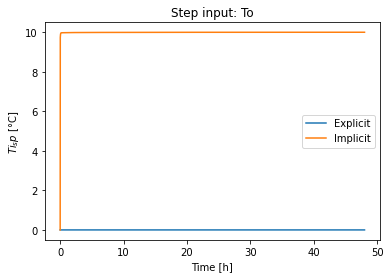

In [50]:
n_s = As.shape[0]                      # number of state variables
θ_exp = np.zeros([n_s, t.shape[0]])    # explicit Euler in time t
θ_imp = np.zeros([n_s, t.shape[0]])    # implicit Euler in time t

I = np.eye(n_s)                        # identity matrix

for k in range (n -1) :
    # θ_exp[:, k + 1] = (I + dt * As).dot(θ_exp[:, k]) + dt * Bs @ u[:, k]
    θ_imp[:, k + 1] = np.linalg.inv(I - dt * As).dot((θ_imp[:, k] + dt * Bs @ u[:, k]))
    
y_exp = Cs @ θ_exp + Ds @  u
y_imp = Cs @ θ_imp + Ds @  u

fig, ax = plt.subplots()
ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
ax.set(xlabel='Time [h]',
       ylabel='$Ti_sp$ [°C]',
       title='Step input: To')
ax.legend(['Explicit', 'Implicit'])
plt.show()

In [51]:
print('Steady-state indoor temperature obtained with:')
print(f'- DAE model: {float(θ[6]):.4f} °C')
print(f'- state-space model: {float(yss):.4f} °C')
print(f'- steady-state response to step input: {float(y_exp[:, -2]):.4f} °C')

Steady-state indoor temperature obtained with:
- DAE model: 21.1454 °C
- state-space model: 21.1454 °C
- steady-state response to step input: 0.0000 °C


Il y a un problème dans le code car les valeurs ne sont pas du tout proche. 

**Conditions de simulation**

* Localisation : Nous étudions toujours le bâtiment au même endroit.

* Flux solaire : Le flux solaire est la somme des flux diffus, réfléchi et direct. Cette partie a déjà été détaillée plus haut, nous reprendrons donc les résultats précédemment établis (flux sur murs nord, est, sud, ouest)

* Resample weather data : Défnir pas delta t et associée à chaque itération une valeur de weather_data

* Autres données : Ti_sp et Qa (flux auxiliaire) sont considérés constants tout le long de la simulation

* Input vector : u à redéfinir

* Condition initiale : A t = 0, on choisis de fixer θ à 0.
  
Ainsi il vient, 

In [52]:
# FLux solaire
# Gtot = Gtot_NEO + Gtot_S
rad_surf['Gtot_S'] = rad_surf.sum(axis=1)

# Resample weather data
data = pd.concat([weather_data['temp_air'], rad_surf['Gtot_S']], axis=1)   # Redéfinition de data
data = data.resample(str(dt) + 'S').interpolate(method='linear')
data = data.rename(columns={'temp_air': 'To'})
pd.DataFrame(data)

# Autres données
data['Ti_sp'] = 15 * np.ones(data.shape[0])
data['Qa'] = 0 * np.ones(data.shape[0])
pd.DataFrame(data) # ou 100 comme au steady-state

# Input Vector
To = data['To']
Ti_sp = data['Ti_sp']
Φo = α_coulc * wall['Surface']['Beton'] * data['Gtot_S']
Φi = τ_vc * α_coulc * wall['Surface']['Verre'] * data['Gtot_S']
Qa = data['Qa']
Φa = α_vc * wall['Surface']['Verre'] * data['Gtot_S']

u = pd.concat([To, To, To, Ti_sp, Φo, Φi, Qa, Φa], axis=1)
u.columns.values[[4, 5, 7]] = ['Φo', 'Φi', 'Φa']
pd.DataFrame(u)

# Initial condition
θ_exp = 0 * np.ones([As.shape[0], u.shape[0]])

**Intégration temporelle**

In [53]:
# Par la méthode explicite d'Euler
for k in range(u.shape[0] - 1):
    θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k]\
        + dt * Bs @ u.iloc[k, :]
    
# Détermination de output vector et q_hvac
y_exp = Cs @ θ_exp + Ds @ u.to_numpy().T
q_hvac = Kp * (data['Ti_sp'] - y_exp[0, :]) # Pour tout t dans duration
np.shape(y_exp)

(1, 41401)

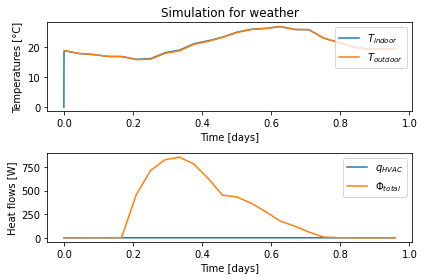

In [54]:
i = np.arange(data.shape[0])
t = dt * i  # time vector

fig, axs = plt.subplots(2, 1)
# plot indoor and outdoor temperature
axs[0].plot(t / 3600 / 24, y_exp[0, :], label='$T_{indoor}$')
axs[0].plot(t / 3600 / 24, data['To'], label='$T_{outdoor}$')
axs[0].set(xlabel='Time [days]',
           ylabel='Temperatures [°C]',
           title='Simulation for weather')
axs[0].legend(loc='upper right')

# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600 / 24,  q_hvac, label='$q_{HVAC}$')
axs[1].plot(t / 3600 / 24, data['Gtot_S'], label='$Φ_{total}$')
axs[1].set(xlabel='Time [days]',
           ylabel='Heat flows [W]')
axs[1].legend(loc='upper right')

fig.tight_layout()

In [55]:
# Surface du mur (béton)
ε_bg = 0.85       # Emissivité : Grande longueur d'onde
α_coulc = 0.25    # Absorptivité : Courte longueur d'onde : mur de couleur blanche

# Verre
ε_vg = 0.90       # Emissivité : Grande longueur d'onde
α_vc = 0.38       # Absorptivité : Courte longueur d'onde
τ_vc = 0.30       # Transmittance : Courte longueur d'onde
t = dt * np.arange(data.shape[0])
t

array([    0,     2,     4, ..., 82796, 82798, 82800])

**Fin du code en dynamique**

## Optimisation du système : Equipement idéal

### Valeurs visées pour chacun des environnements

On cherche à atteindre une certaine température, dite température de confort Ti_sp, en ne modifiant que les équipements superficiels de notre bâtiment et sans consommation d'un climatiseur ou d'un chauffage. Afin de souligner les modifications superficielles du système, on ajoute 2 autres environnements : un de température moyenne tiède, un plutôt chaude.

* Cas de la Russie : Ti_sp = 15 °C
* Cas de l'Argentine : Ti_sp = 22 °C
* Cas de l'Afrique du Sud : Ti_sp = 16 °C

### Paramètres modifiables

Pour atteindre cette température, il est possible de modifier :  
1) les matériaux superficiels  
2) la couleur des murs en surface  
3) l'épaisseur des 4 murs  

### Tableau des matériaux

En se basant sur le tableau d'émissivité stocké dans le Stock doc :

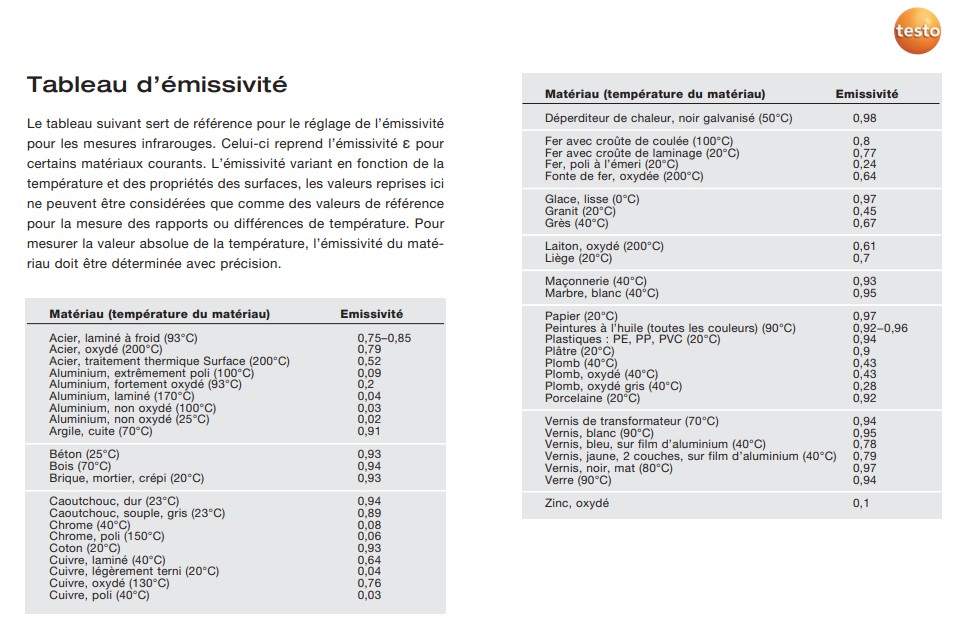
> Figure 7. Tableau d'émissivité

On définira nos propriétés pour les matériaux que nous choisirons pour construire notre bati par la suite. 
On fera attention au condition de température dans laquelle l'expérience a été réalisé pour trouver la valeur d'émissivité. Ainsi, par prudence, car les températures de réalisations sont très différentes de nos conditions environnementales, on prendra des valeurs plus faibles que celles inscrites (comparaison de valeurs avec le béton car fixée à 0.85 dans ce projet alors qu'il est égal à 0.93 dans le tableau).

Voici la liste des matériaux sélectionnés pour l'étude :

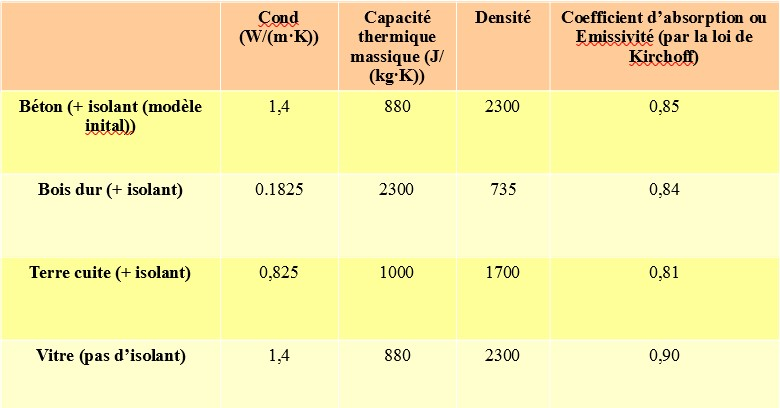
> Figure 8. Tableau des matériaux sélectionnés dans le cadre du projet

### Processus de détermination des équipements idéaux

La température intérieure T6 est affinée selon nos modifications.

On commence par le choix des matéraux parmis ceux de la liste ci-dessus. 
Pour cela, il faut importer les fichiers weather_data de l'Argentine et de l'Afrique du Sud et modifier ensuite les paramètres qui caractérisent chaque matériau soit la conductivité, la capacité thermique, la densité et enfin le coefficient d'émissivité.
(code dans définition des matériaux utilisés)

Ce qui nous donne :
* Russie  
Béton + isolant : T6 = -1.687 °C
Bois + isolant : T6 = -1.687 °C
Terre cuite + isolant : T6 = -1.687 °C
Vitre + isolant : -1.68 °C

A première vue, on constate que les températures sont variées au centième près, la modification des propriétés des matériaux n'influencent pas la température intérieure de la maison. Il est à ce stade difficile de voir quel matériau serait idéal pour le confort de la maison dans son environnemet.

* Argentine # albedo = 0.2  
Béton + isolant : T6 = 24.982 °C
Bois + isolant : T6 = 24.981 °C
Terre cuite + isolant : T6 = 24.982 °C
Vitre + isolant : 25.015 °C

* Affrique du Sud # albdeo = 0.2
Béton + isolant : T6 = 21.145 °C
Bois + isolant : T6 = 21.144 °C
Terre cuite + isolant : T6 = 21.445 °C
Vitre + isolant : 21.192 °C

Sachant que les températures de confort sont différentes pour chacun des cas (cf Valeurs visées pour chacun des environnements), on va donc soit chercher à réchauffer la maison soit à le refroidir.
Ainsi, on sélectionne (en gras) pour la Russie le matériau qui permet d'augmenter le plus possible la température intérieure et pour les 2 autres pays, on réalise le processus inverse : 

* Russie  
Béton + isolant : T6 = -1.687 °C
Bois + isolant : T6 = -1.687 °C
Terre cuite + isolant : T6 = -1.687 °C
**Vitre + isolant : -1.68 °C**

* Argentine # albedo = 0.2  
Béton + isolant : T6 = 24.982 °C
**Bois + isolant : T6 = 24.981 °C**
Terre cuite + isolant : T6 = 24.982 °C
Vitre + isolant : 25.015 °C

* Affrique du Sud # albdeo = 0.2
Béton + isolant : T6 = 21.145 °C
**Bois + isolant : T6 = 21.144 °C**
Terre cuite + isolant : T6 = 21.445 °C
Vitre + isolant : 21.192 °C

Maintenant que nous avons définis le matériau, on va chercher à modifier le bati grâce à différentes solutions selon les besoins de chaque cas.
Pour l'Argentine et l'Afrique, il est encore possible de modifier l'épaisseur en l'augmentant. Le mur étant déjà de couleur blanche, il n'est pas possible de modifier la couleur sans qu'elle augmente la température intérieure de la pièce.
La Russie a des besoins totalement différentes. La température est glaciale, l'objectif est de réchauffer la pièce. Aisni, il est possible de diminuer l'épaisseur des vitres et de tendre la couleur vers le noir pour une plus absorptivité.

En changeant l'épaisseur : 
la Russie a gagné 0.009 °C, l'Argentine a perdu 0.002 °C et l'Afrique du Sud 0.003 °C.

De même avec des modifications sur la couleur :
La Russie en gagne 0.047 de plus, ce qui est énorme par rapport à la variation de température due à la modification de l'épaisseur.

On souligne qu'en terme d'efficacité, il est préférable de changer la couleur de la peinture plutôt que l'épaisseur et même le matériau lui-même.

### Conclusion 

L'objectif au départ était de moins consommer le climatiseur et le chauffage en modifiant les équipements superficiels du bâtiment afin de tendre la température intérieure le plus possible vers la température de confort.
D'après les différentes simulations, la modification la plus efficace est celle de la couleur plutôt que l'épaisseur et le matériau. 
De plus, pour chauffer une maison, il faut réduire les épaisseurs des murs ce qui est limité car on atteint vite le 0, il faut donc miser sur d'autres paramètres. Pour climatiser une pièce, il faut au contraire augmenter les épaisseurs mais sont très épuisables en termes de ressource pour en réalité pas grand résultat.
En effet, les variations de température se font au centième, ce qui est négligeable à notre échelle car c'est trop précis.

Ainsi, nous pouvons en conclure que modifier les matériaux, les épaisseurs et la couleur des murs influencent très peu la température intérieure. La température intérieure et extérieure sont quasiment les mêmes. Il faut trouver un compromis pour construire un batîment faisable et qui se rapproche le plus possible de notre température idéale à l'intérieur de la maison.

## Amélioration possible

Le modèle actuel n'est pas une représentation exacte de la réalité. Pour plusieurs raisons qui sont énumérés comme suit :
* Les flux solaires éclairent uniquement les faces Sud et Est des murs. Alors qu'il y a également toutes les autres faces. Il y a donc plus de réchauffement de la pièce.
* Les flux radiatifs sont en réalité comptés entre les surfaces internes. Cela fausse donc également les résultats qui s'orientent vers une augmentation de la température.
* La conversion du modèle en dynamique n'a pas pu être réalisé, cela aurait pu nous rapprocher plus du modèle de la réalité.
* Les échanges radiatifs à l'intérieur du cube auraient pu modifier des résultats notamment dans la partie modification des couleurs qui a fait bouger un peu le modèle.